In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.datasets import fetch_openml 

mnist = fetch_openml("mnist_784", version=1, as_frame=False, parser='auto')
X,y = mnist.data, mnist.target

In [50]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [2]:
print(mnist.data.shape, mnist.target.shape)
#Full set, this will take a VERY long time to train. So use for final fit.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 50)

#Partial set to speed up initial training
#X_train, X_test, y_train, y_test = train_test_split(X[:20000], y[:20000], test_size=0.2, random_state= 50)
print(X_train.shape, X_test.shape)

(70000, 784) (70000,)
(56000, 784) (14000, 784)


In [3]:
"""
StandardScaler : It transforms the data in such a manner that it has mean as 0 and standard deviation as 1. 
In short, it standardizes the data. Standardization is useful for data which has negative values. 
It arranges the data in a standard normal distribution. It is more useful in classification than regression
"""

# Using StandardScaler to scale down.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  


### Start by trying out a few models

In [6]:
# Using models
SVC_MAX_ITER = -1
MAX_ITER = 5000
N_JOBS = 12
svmL = SVC(kernel='linear', random_state=50, max_iter=SVC_MAX_ITER) # n_jobs not available as param
svmP = SVC(kernel='poly', random_state=50, max_iter=SVC_MAX_ITER)
svmR = SVC(kernel='rbf', random_state=50, max_iter=SVC_MAX_ITER)
sgd = SGDClassifier(n_jobs=N_JOBS, random_state=50, max_iter=MAX_ITER)  # max_iter of -1 is not accepted       
reg = LogisticRegression(n_jobs=N_JOBS, random_state=50, max_iter=MAX_ITER) # max_iter of -1 is not accepted 

estimators = [svmL, svmP, svmR, sgd, reg]
estimateX = X_train_scaled 
estimatey = y_train

for estimator in estimators:
    start = datetime.datetime.now()
    print("Starting new fit: ")
    
    estimator.fit(estimateX, estimatey)
    end = datetime.datetime.now()
    print(f"Time of running fit for: \n {estimator}:  ", end - start,"\n")

Starting new fit: 
Time of running fit for: 
 SVC(kernel='linear', random_state=50):   0:00:10.931671 

Starting new fit: 
Time of running fit for: 
 SVC(kernel='poly', random_state=50):   0:01:04.707381 

Starting new fit: 
Time of running fit for: 
 SVC(random_state=50):   0:00:30.614608 

Starting new fit: 
Time of running fit for: 
 SGDClassifier(max_iter=5000, n_jobs=12, random_state=50):   0:00:20.435338 

Starting new fit: 
Time of running fit for: 
 LogisticRegression(max_iter=5000, n_jobs=12, random_state=50):   0:00:17.507997 



### Check initial results and accuracy on test data

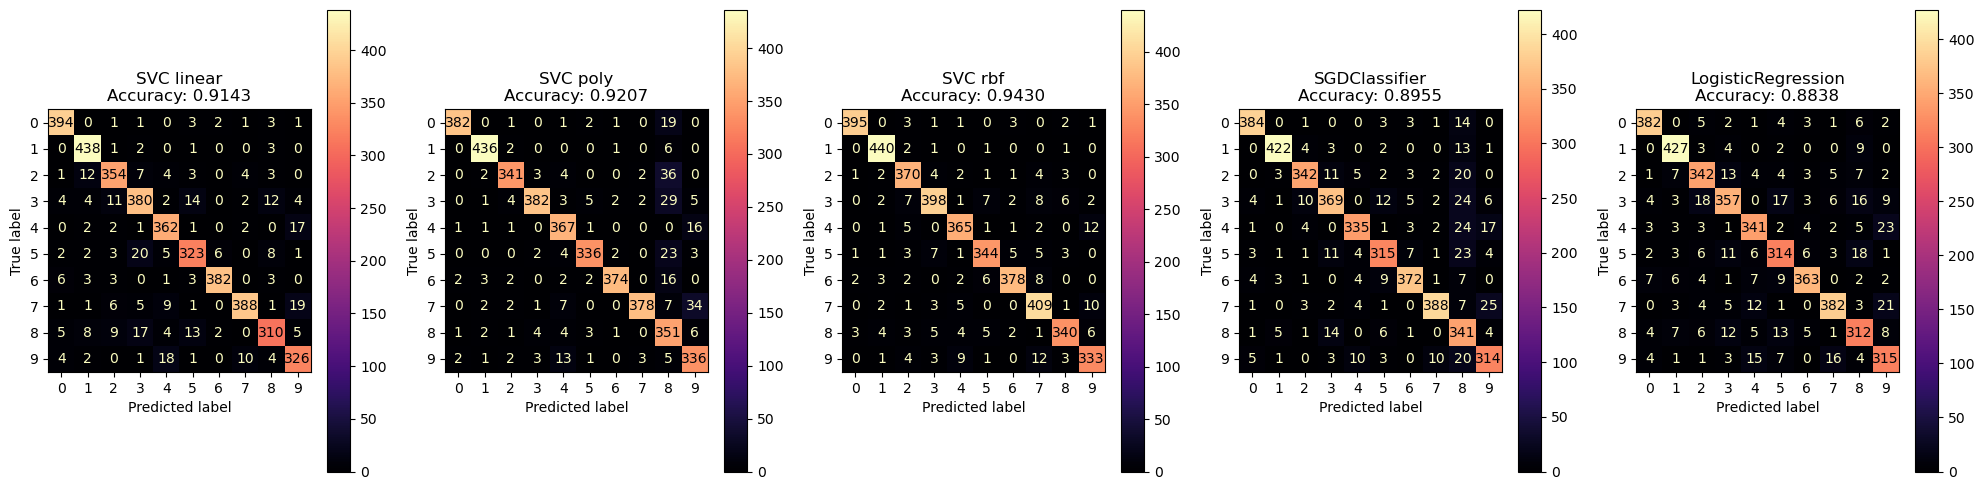

In [18]:
#Predictions on test data
y_pred1 = svmL.predict(X_test_scaled)
y_pred2 = svmP.predict(X_test_scaled)
y_pred3 = svmR.predict(X_test_scaled)
y_pred4 = sgd.predict(X_test_scaled)
y_pred5 = reg.predict(X_test_scaled)

# Calculate accuracy and matrices for each classifier
classifiers = ["SVC linear", "SVC poly", "SVC rbf", "SGDClassifier", "LogisticRegression"]
accuracies = []
confusion_matrices = []

for classifier, y_pred in zip(classifiers, [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5]):
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    accuracies.append(accuracy)
    confusion_matrices.append(cm)


fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for idx, (classifier, accuracy, cm) in enumerate(zip(classifiers, accuracies, confusion_matrices)):
    ax[idx].set_title(f"{classifier}\n Accuracy: {accuracy:.4f}")
    ConfusionMatrixDisplay(cm).plot(ax=ax[idx], cmap='magma')

plt.tight_layout()
plt.show()

### Since SVC gives the best results, use GridSearchCV on that model

In [21]:
"""
A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
C is 1 by default. If you have a lot of noisy observations you should decrease C
Gamma defines how much influence a single training example has. 
The larger gamma is, the closer other examples must be to be affected. 
The higher the gamma, the more complex the model, the higher the risk of overfitting.
"""


params = {
    'C': [1, 5, 15, 25, 50],  
    'kernel': ['rbf'],
    'gamma': [10, 1, 0.1, 0.01, 0.001] 
}

svc = SVC(
            max_iter=SVC_MAX_ITER,
            random_state=50)

# find best params
svcGS = GridSearchCV(estimator=svc, param_grid=params, scoring='accuracy', n_jobs=12)

# Fit to the training data
start = datetime.datetime.now()
print("Starting fit: ")

svcGS.fit(X_train_scaled, y_train)
end = datetime.datetime.now()
print(f"Time of running fit for {svcGS}: ", end - start,"\n")

# Print the best parameters found
print("Best Parameters:", svcGS.best_params_)

Starting fit for:  GridSearchCV(estimator=SVC(random_state=50), n_jobs=12,
             param_grid={'C': [1, 5, 15, 25, 50],
                         'gamma': [10, 1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             scoring='accuracy')
Time of running fit for GridSearchCV(estimator=SVC(random_state=50), n_jobs=12,
             param_grid={'C': [1, 5, 15, 25, 50],
                         'gamma': [10, 1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             scoring='accuracy'):  1:45:24.320122 

Best Parameters: {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
print("Best CV accuracy", svcGS.best_score_)

In [4]:
params2 = {
    'C': [1, 5, 10],  
    'kernel': ['poly'],
    'gamma': [10, 1, 0.001] 
}

svc2 = SVC(
            max_iter= -1,
            random_state=50)

# find best params
svcGS2 = GridSearchCV(estimator=svc2, param_grid=params2, scoring='accuracy', n_jobs=12)

# Fit to the training data
start = datetime.datetime.now()
print("Starting fit: ")

svcGS2.fit(X_train_scaled, y_train)
end = datetime.datetime.now()
print(f"Time of running fit for {svcGS2}: ", end - start,"\n")

# Print the best parameters found
print("Best Parameters:", svcGS2.best_params_)

Starting fit: 
Time of running fit for GridSearchCV(estimator=SVC(random_state=50), n_jobs=12,
             param_grid={'C': [1, 5, 10], 'gamma': [10, 1, 0.001],
                         'kernel': ['poly']},
             scoring='accuracy'):  1:30:54.351483 

Best Parameters: {'C': 1, 'gamma': 10, 'kernel': 'poly'}


In [5]:
print("Best CV accuracy", svcGS2.best_score_)

Best CV accuracy 0.9775


In [44]:
import pandas as pd
# results
cv_results = pd.DataFrame(svcGS.cv_results_)

# Get the top five best parameters and best scores
top_results = np.argsort(cv_results['mean_test_score'])[::-1][:5]

print("Top 5 Best Parameters:")
for i, idx in enumerate(top_results):
    print(f"{i+1}. Parameters: {cv_results['params'][idx]}, Mean Test Score: {cv_results['mean_test_score'][idx]:.4f}")

Top 5 Best Parameters:
1. Parameters: {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Test Score: 0.9561
2. Parameters: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Test Score: 0.9559
3. Parameters: {'C': 25, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Test Score: 0.9558
4. Parameters: {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Test Score: 0.9556
5. Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Test Score: 0.9455


In [ ]:
cv_results

### Make a prediction based on the gridsearch best params

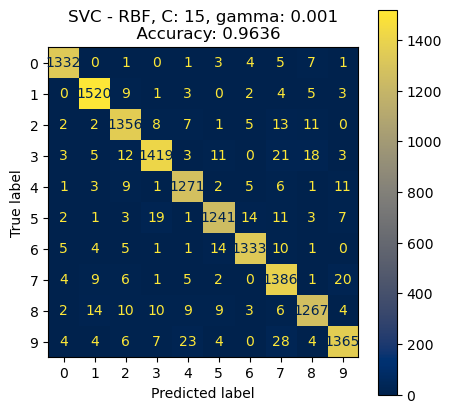

In [38]:
# prediction - Best Parameters: {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}
bestC = 1
bestG = 0.001

# Run new fit with optimal params
svm_final = SVC(kernel='rbf', C=bestC, gamma=bestG)
svm_final.fit(X_train_scaled, y_train)

y_pred_final = svm_final.predict(X_test_scaled)
ac_sc = accuracy_score(y_true=y_test, y_pred=y_pred_final)

# paint it up
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"SVC - RBF, C: 15, gamma: 0.001\n  Accuracy: {ac_sc:.4f}")
cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='cividis')
plt.show()

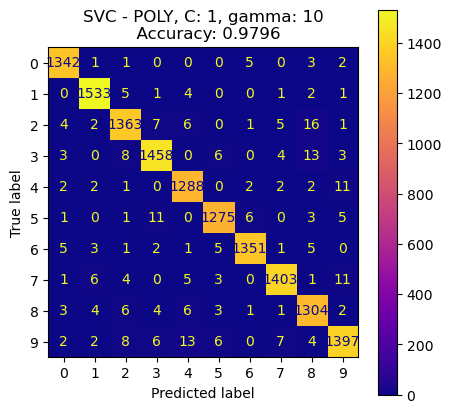

In [7]:
# prediction - Best Parameters: {'C': 1, 'gamma': 10, 'kernel': 'poly'}
bestCp = 1
bestGp = 10

# Run new fit with optimal params
svm_final2 = SVC(kernel='poly', C=bestCp, gamma=bestGp)
svm_final2.fit(X_train_scaled, y_train)

y_pred_final2 = svm_final2.predict(X_test_scaled)
ac_sc2 = accuracy_score(y_true=y_test, y_pred=y_pred_final2)

# paint it up
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"SVC - POLY, C: 1, gamma: 10\n  Accuracy: {ac_sc2:.4f}")
cm = confusion_matrix(y_test, y_pred_final2)
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='plasma')
plt.show()

In [39]:
# Save the model
path = 'C:\\Users\\D.B\\Streamlit\\'
#trained_model = path+'Svc_C-15_gamma-001_kernel-rbf.sav'
trained_model = path+'Svc_C-15_gamma-001_kernel-rbf-FULLSET.sav'
joblib.dump(svm_final, trained_model)

['C:\\Users\\D.B\\Streamlit\\Svc_C-15_gamma-001_kernel-rbf-FULLSET.sav']

In [8]:
# Save the model
path = 'C:\\Users\\D.B\\Streamlit\\'
#trained_model = path+'Svc_C-15_gamma-001_kernel-rbf.sav'
trained_model2 = path+'Svc_C-1_gamma-10_kernel-POLY-FULLSET.sav'
joblib.dump(svm_final2, trained_model2)

['C:\\Users\\D.B\\Streamlit\\Svc_C-1_gamma-10_kernel-POLY-FULLSET.sav']

In [ ]:
# load the model from disk in case it has taken a long time to fit
loaded = joblib.load(trained_model)

#loaded.predict(X_test_scaled)